<a href="https://www.kaggle.com/code/robiulislamrubel/breast-cancer-classification-94-12?scriptVersionId=158694709" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image


# Loading Dataset

In [2]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


# Visualizing Dataset

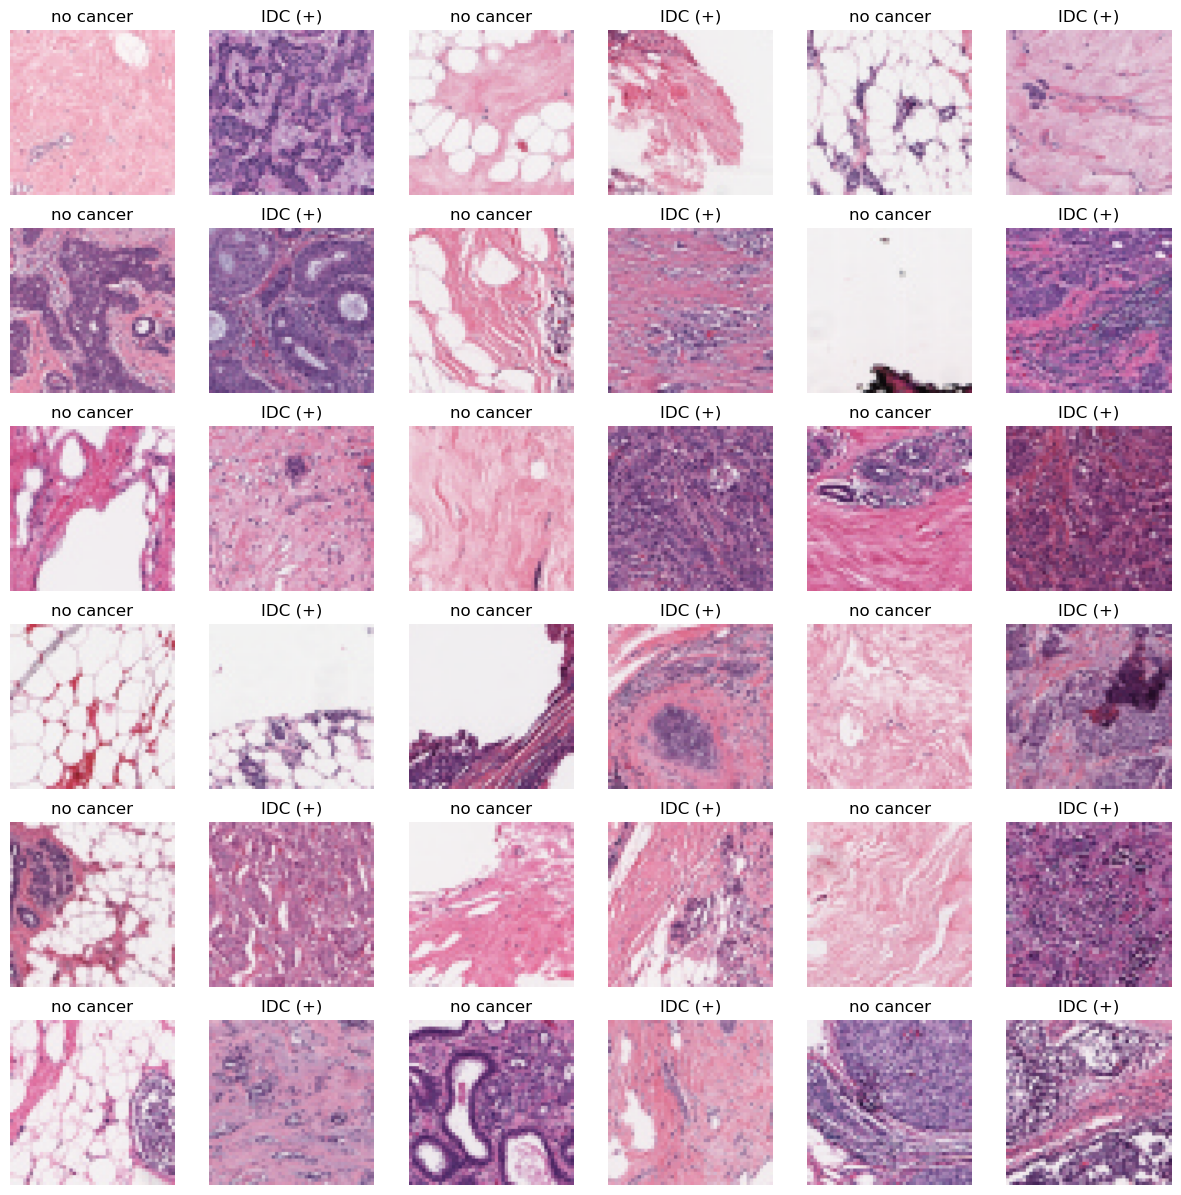

In [3]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1


In [4]:
NewN_IDC=N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


# Data Preprocessing

In [5]:
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])


In [6]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

78786
78786
157572


In [7]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr[:12389], can_img_arr[:12389]))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [8]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)


Total number of images: 24778
Number of IDC(-) Images: 21065
Number of IDC(+) Images: 3713
Image shape (Width, Height, Channels): (50, 50, 3)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (17344, 50, 50, 3)
Testing Data Shape: (7434, 50, 50, 3)


# Modeling

In [10]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools


In [11]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [12]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                        

In [14]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 40, batch_size = 35)


Epoch 1/40


2024-01-12 11:08:46.720318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


496/496 [==============================] - 21s 17ms/step - loss: 0.3449 - accuracy: 0.8669 - val_loss: 0.2704 - val_accuracy: 0.8920
Epoch 2/40
496/496 [==============================] - 8s 16ms/step - loss: 0.2743 - accuracy: 0.8927 - val_loss: 0.2918 - val_accuracy: 0.8861
Epoch 3/40
496/496 [==============================] - 8s 16ms/step - loss: 0.2513 - accuracy: 0.9012 - val_loss: 0.4070 - val_accuracy: 0.8138
Epoch 4/40
496/496 [==============================] - 8s 16ms/step - loss: 0.2349 - accuracy: 0.9064 - val_loss: 0.2665 - val_accuracy: 0.8906
Epoch 5/40
496/496 [==============================] - 8s 16ms/step - loss: 0.2220 - accuracy: 0.9107 - val_loss: 0.2956 - val_accuracy: 0.8857
Epoch 6/40
496/496 [==============================] - 8s 16ms/step - loss: 0.2114 - accuracy: 0.9166 - val_loss: 0.2766 - val_accuracy: 0.8766
Epoch 7/40
496/496 [==============================] - 8s 16ms/step - loss: 0.1987 - accuracy: 0.9222 - val_loss: 0.2489 - val_accuracy: 0.9105
Epoch 8/4

# Model Evaluation

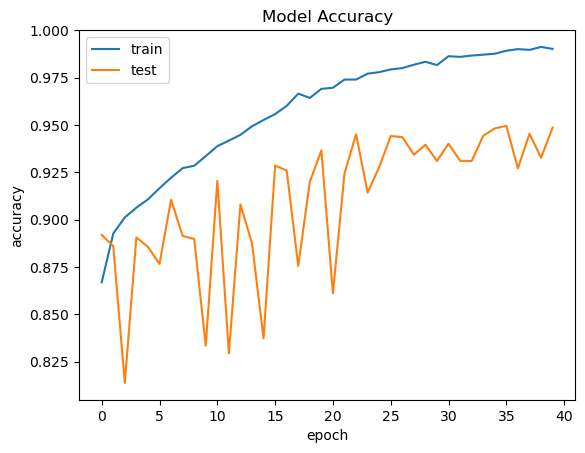

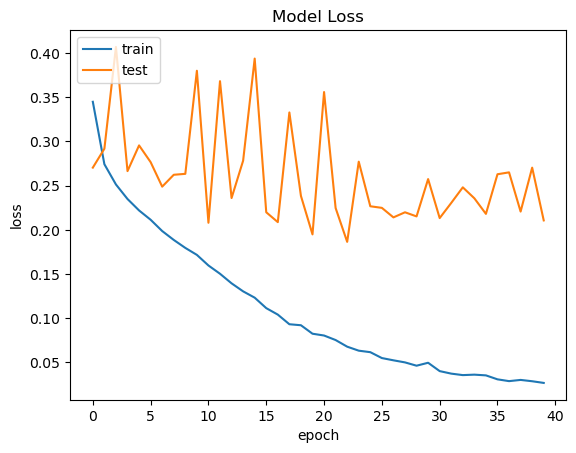

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


233/233 [==============================] - 1s 3ms/step


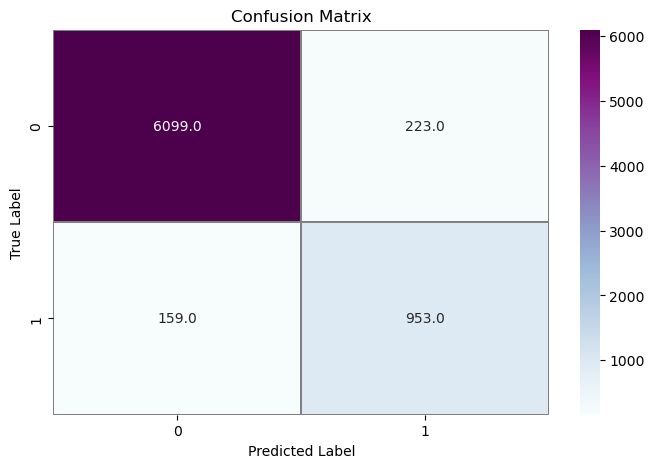

In [16]:
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


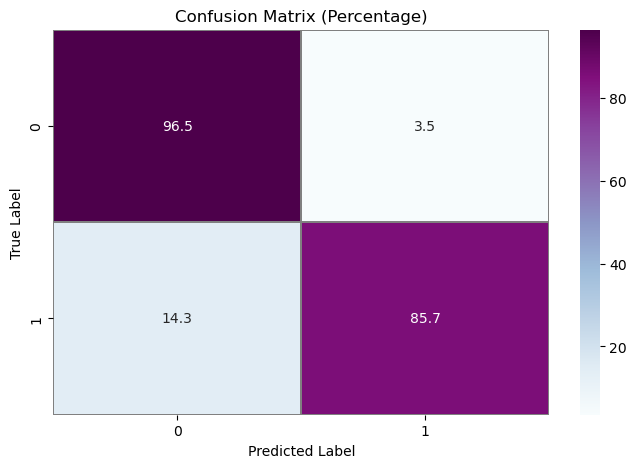

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1) 
Y_true = np.argmax(Y_test, axis=1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()


In [18]:
model.evaluate(X_test,Y_test)

233/233 [==============================] - 1s 5ms/step - loss: 0.2107 - accuracy: 0.9486


[0.21068435907363892, 0.9486144781112671]

# Testing

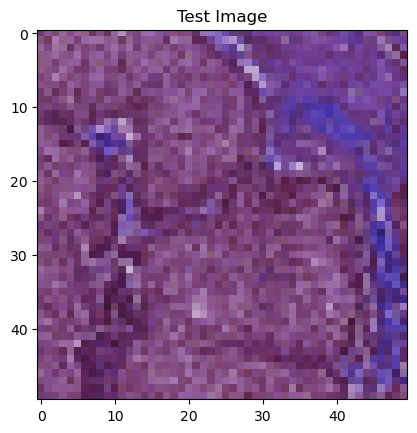

In [19]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
    
index = 1000
img_plot(X_test, index)

In [20]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
index = 4000
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)


1/1 [==============================] - 0s 120ms/step
Predicted Value using  cnn model 0
True Value 0


# **VGG MODEL**

In [21]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Model

vgg_model=VGG16(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                              

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 40, batch_size = 500)


Epoch 1/40
35/35 [==============================] - 43s 801ms/step - loss: 18.3856 - accuracy: 0.8371 - val_loss: 0.4214 - val_accuracy: 0.8504
Epoch 2/40
35/35 [==============================] - 14s 415ms/step - loss: 0.4033 - accuracy: 0.8500 - val_loss: 0.4180 - val_accuracy: 0.8504
Epoch 3/40
35/35 [==============================] - 14s 409ms/step - loss: 0.3655 - accuracy: 0.8500 - val_loss: 0.3612 - val_accuracy: 0.8504
Epoch 4/40
35/35 [==============================] - 14s 408ms/step - loss: 0.3404 - accuracy: 0.8574 - val_loss: 0.3246 - val_accuracy: 0.8729
Epoch 5/40
35/35 [==============================] - 14s 411ms/step - loss: 0.3347 - accuracy: 0.8639 - val_loss: 0.3293 - val_accuracy: 0.8528
Epoch 6/40
35/35 [==============================] - 15s 417ms/step - loss: 0.3169 - accuracy: 0.8748 - val_loss: 0.3243 - val_accuracy: 0.8688
Epoch 7/40
35/35 [==============================] - 15s 416ms/step - loss: 0.3270 - accuracy: 0.8737 - val_loss: 0.3113 - val_accuracy: 0.877

# ResNet

In [24]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the full model
resnet50_model = ResNet50(include_top=False,
                    input_shape=(50, 50, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [25]:
# model compile
resnet50_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 40, batch_size = 500)


Epoch 1/40
35/35 [==============================] - 15s 419ms/step - loss: 0.1065 - accuracy: 0.9671 - val_loss: 0.2290 - val_accuracy: 0.9298
Epoch 2/40
35/35 [==============================] - 15s 421ms/step - loss: 0.1095 - accuracy: 0.9626 - val_loss: 0.2109 - val_accuracy: 0.9333
Epoch 3/40
35/35 [==============================] - 15s 420ms/step - loss: 0.1237 - accuracy: 0.9576 - val_loss: 0.2465 - val_accuracy: 0.9239
Epoch 4/40
35/35 [==============================] - 15s 417ms/step - loss: 0.1080 - accuracy: 0.9647 - val_loss: 0.2273 - val_accuracy: 0.9354
Epoch 5/40
35/35 [==============================] - 15s 416ms/step - loss: 0.0738 - accuracy: 0.9772 - val_loss: 0.2644 - val_accuracy: 0.9356
Epoch 6/40
35/35 [==============================] - 15s 416ms/step - loss: 0.1058 - accuracy: 0.9644 - val_loss: 0.2263 - val_accuracy: 0.9291
Epoch 7/40
35/35 [==============================] - 15s 417ms/step - loss: 0.0808 - accuracy: 0.9738 - val_loss: 0.2359 - val_accuracy: 0.9387

# VGG-19

In [26]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg_model=VGG19(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                            

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 40, batch_size = 500)

Epoch 1/40
35/35 [==============================] - 23s 508ms/step - loss: 7.0898 - accuracy: 0.8178 - val_loss: 0.3876 - val_accuracy: 0.8504
Epoch 2/40
35/35 [==============================] - 18s 506ms/step - loss: 0.3500 - accuracy: 0.8500 - val_loss: 0.3179 - val_accuracy: 0.8504
Epoch 3/40
35/35 [==============================] - 17s 499ms/step - loss: 0.3179 - accuracy: 0.8500 - val_loss: 0.3070 - val_accuracy: 0.8504
Epoch 4/40
35/35 [==============================] - 17s 493ms/step - loss: 0.2969 - accuracy: 0.8768 - val_loss: 0.3012 - val_accuracy: 0.8877
Epoch 5/40
35/35 [==============================] - 17s 493ms/step - loss: 0.2826 - accuracy: 0.8886 - val_loss: 0.2714 - val_accuracy: 0.8936
Epoch 6/40
35/35 [==============================] - 17s 495ms/step - loss: 0.2757 - accuracy: 0.8896 - val_loss: 0.2712 - val_accuracy: 0.8941
Epoch 7/40
35/35 [==============================] - 17s 497ms/step - loss: 0.2721 - accuracy: 0.8923 - val_loss: 0.2646 - val_accuracy: 0.8979

# Model Save

In [28]:
model.save("/kaggle/working/Brest CNN 2.h5")
